# Identifying the type of blood cells from images
![dataset-cover.jpg](dataset-cover.jpg)  
The diagnosis of blood-based diseases often involves identifying and characterizing patient blood samples.  
So, providing automated methods to detect and classify blood cell subtypes would be a huge benefit and would have important medical applications.

# Data Exploration

This dataset contains 12,500 augmented images of blood cells (JPEG) with accompanying cell type labels (CSV). 

There are approximately 3,000 images for each of 4 different cell types grouped into 4 different folders (according to cell type).

This dataset is accompanied by an additional dataset containing the original 410 images (pre-augmentation) as well as two additional subtype labels (white blood cells WBC vs red blood cells RBC) and also bounding boxes for each cell in each of these 410 images (JPEG + XML metadata).

An example of the labeled cell image.
- Here we have three kind of labels :
- RBC (Red Blood Cell)
- WBC (White Blood Cell)
- Platelets


![example.jpg](example.jpg)

Types of blood cells are :
1. Mononuclear
  - Lymphocyte
  - Monocyte
  - Basophil
2. Polynuclear
  - Eosinophil
  - Neutrophil  


For more information about blood cells and blood cell subtypes, see the following links:
- https://www.ncbi.nlm.nih.gov/books/NBK2263/

- https://www.ncbi.nlm.nih.gov/books/NBK2263/box/A26/?report=objectonly


# Getting Started



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from IPython.display import display # Allows the use of display() for DataFrames

%matplotlib inline


  
## Helper function

Building a ploting function to plot image with annotated boxes for different parts of the image.

**Note**: The function below is adapted from https://github.com/Shenggan/BCCD_Dataset


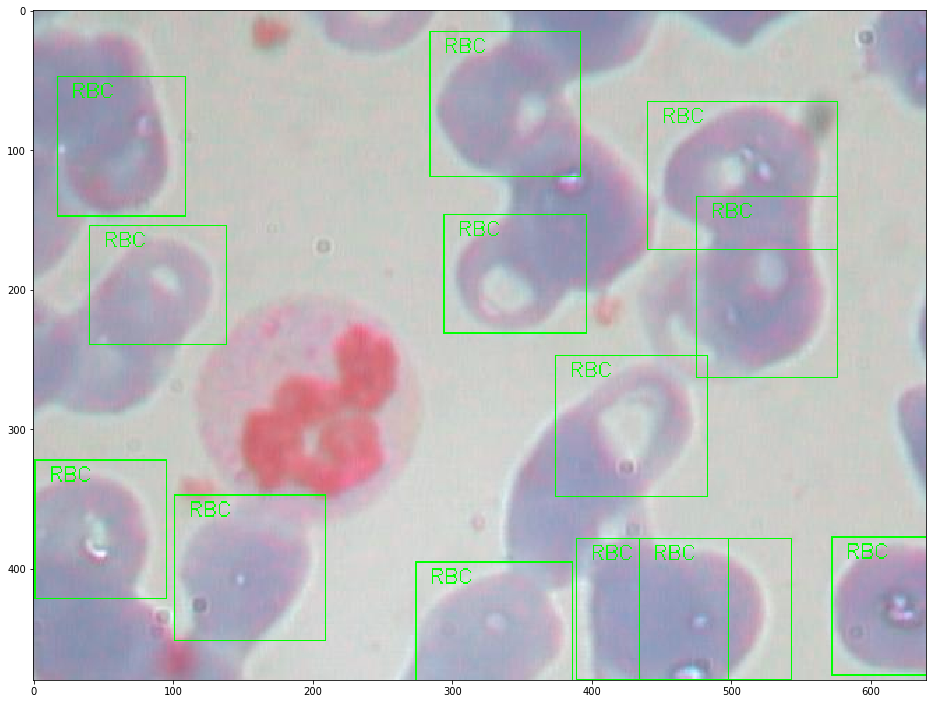

In [3]:
import xml.etree.ElementTree as ET
import cv2

# define the plotying function that takes path to both image and xml files
def plot_image_details(image_path, xml_file):
    image = cv2.imread(image_path)
    tree = ET.parse(xml_file)
    for elem in tree.iter():
        if 'object' in elem.tag or 'part' in elem.tag:
            for attr in list(elem):
                if 'name' in attr.tag:
                    name = attr.text
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                    if name[0] == "R":
                        cv2.rectangle(image, (xmin, ymin),
                                    (xmax, ymax), (0, 255, 0), 1)
                        cv2.putText(image, name, (xmin + 10, ymin + 15),
                                cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 255, 0), 1)
                    if name[0] == "W":
                        cv2.rectangle(image, (xmin, ymin),
                                    (xmax, ymax), (0, 0, 255), 1)
                        cv2.putText(image, name, (xmin + 10, ymin + 15),
                                cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 0, 255), 1)
                    if name[0] == "P":
                        cv2.rectangle(image, (xmin, ymin),
                                    (xmax, ymax), (255, 0, 0), 1)
                        cv2.putText(image, name, (xmin + 10, ymin + 15),
                                cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (255, 0, 0), 1)
    plt.figure(figsize=(16,16))
    plt.imshow(image)
    plt.show()

# call the function
img_path = "dataset/images/BloodImage_00022.jpg"
xml_path = "dataset/annotations/BloodImage_00022.xml"

plot_image_details(img_path, xml_path)


# Data Preprocessing


## Read lables data

In [5]:
# read lables from a csv file
labels = pd.read_csv("dataset/labels.csv")
labels.head(11)

,Image,Category
0,0,NEUTROPHIL
1,1,NEUTROPHIL
2,2,NEUTROPHIL
3,3,NEUTROPHIL
4,4,NEUTROPHIL
5,5,NEUTROPHIL
6,6,NEUTROPHIL
7,7,NEUTROPHIL
8,8,BASOPHIL
9,9,EOSINOPHIL


## Rename columns

In [6]:
labels = labels.rename(index=str, columns={"Image": "Id", "Category": "Type"})
labels.head(11)

,Id,Type
0,0,NEUTROPHIL
1,1,NEUTROPHIL
2,2,NEUTROPHIL
3,3,NEUTROPHIL
4,4,NEUTROPHIL
5,5,NEUTROPHIL
6,6,NEUTROPHIL
7,7,NEUTROPHIL
8,8,BASOPHIL
9,9,EOSINOPHIL


## Remove records with missing values

In [7]:
# remove records with missing values
print("Number of records before filtering:", labels.shape[0])
labels = labels.dropna()
print("Number of records after filtering:", labels.shape[0])
labels.head(11)

Number of records before filtering: 411
Number of records after filtering: 367


,Id,Type
0,0,NEUTROPHIL
1,1,NEUTROPHIL
2,2,NEUTROPHIL
3,3,NEUTROPHIL
4,4,NEUTROPHIL
5,5,NEUTROPHIL
6,6,NEUTROPHIL
7,7,NEUTROPHIL
8,8,BASOPHIL
9,9,EOSINOPHIL


## Exclude labels corresponding to non-existing images

In [8]:
image_folder = 'dataset/images/'
indexes_to_remove = []
for id in labels['Id']:
    image_no = "0" * (5-len(str(id))) + str(id)
    image_name = "BloodImage_" + image_no + ".jpg"
    image_file = cv2.imread(image_folder + image_name)
    if image_file is None:
        print("'{}' removed".format(image_name))
        indexes_to_remove.append(id)

# remove records with no coresponding labels
print("\nNumber of records before filtering:", labels.shape[0])
labels = labels.loc[~labels['Id'].isin(indexes_to_remove)]
print("Number of records after filtering:", labels.shape[0])  

# save modified labels into file
labels.to_csv('dataset/mod_labels.csv', index=False)

'BloodImage_00116.jpg' removed
'BloodImage_00280.jpg' removed

Number of records before filtering: 367
Number of records after filtering: 365


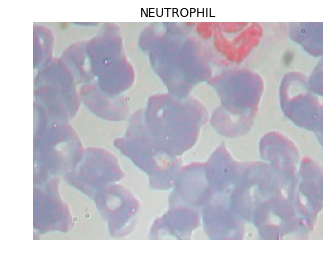

In [9]:
# Creating a ploting function to plot image along with its label
def plot_image(image_path):
    index = int(image_path.split("_")[-1].split(".")[0])  # extracting the image number from the path name
    title = labels.iloc[index]['Type']
    image = cv2.imread(image_path)
    plt.title(title)
    plt.axis('off')
    plt.imshow(image)
    return

# make sample calls
img_path = "dataset/images/BloodImage_00002.jpg"
plot_image(img_path)


## Data Description: Blood types distribution

It's important to view the distribution of datapoints for the different classes, as we want to know if the is impalanced or not.

BASOPHIL        4
MONOCYTE       22
LYMPHOCYTE     37
EOSINOPHIL     94
NEUTROPHIL    216
dtype: int64


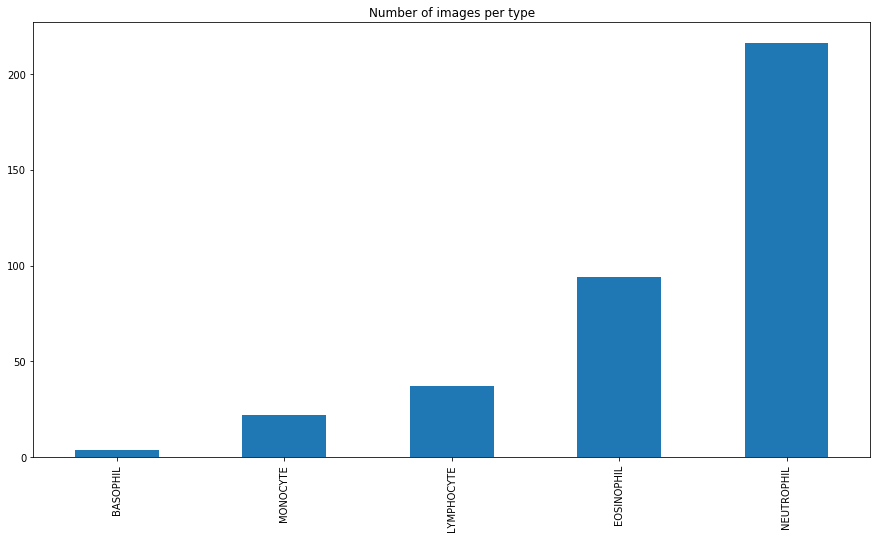

In [10]:
import string
blood_types = ['LYMPHOCYTE','MONOCYTE', 'BASOPHIL','EOSINOPHIL','NEUTROPHIL']
blood_types_count = [len(labels.loc[labels['Type'].str.find(blood_types[0]) != -1]),
               len(labels.loc[labels['Type'].str.find(blood_types[1]) != -1]),
               len(labels.loc[labels['Type'].str.find(blood_types[2]) != -1]),
               len(labels.loc[labels['Type'].str.find(blood_types[3]) != -1]),
               len(labels.loc[labels['Type'].str.find(blood_types[4]) != -1])]


# plot the distribution of blood types
blood_types_series = pd.Series(blood_types_count, index=blood_types).sort_values()
print(blood_types_series)
blood_types_series.plot.bar(title="Number of images per type", figsize=(15,8))


Here we can see that with the original images we have *imbalanced* class sizes.

## Execluding the 'BASOPHIL' class

In [11]:
# samples of 'BASOPHIL' class
labels.loc[labels['Type'].str.find('BASOPHIL') != -1]


,Id,Type
8,8,BASOPHIL
34,34,"NEUTROPHIL,BASOPHIL"
132,132,BASOPHIL
171,171,BASOPHIL


Since this class has only 4 samples, we will exclude it.

In [12]:
print("\nNumber of records before filtering:", labels.shape[0])
labels = labels.loc[labels['Type'].str.find('BASOPHIL') == -1]
print("Number of records after filtering:", labels.shape[0])


Number of records before filtering: 365
Number of records after filtering: 361


  
## Load image data


In [13]:
import scipy

images = []
for id in labels['Id']:
    image_no = "0" * (5-len(str(id))) + str(id)
    image_name = "BloodImage_" + image_no + ".jpg"
    image_file = cv2.imread(image_folder + image_name)
    image_file = scipy.misc.imresize(arr=image_file, size=(60, 80, 3))
    image_array = np.asarray(image_file)
    images.append(image_array)


"""
import skimage.transform

images = []
for id in labels['Id']:
    image_no = "0" * (5-len(str(id))) + str(id)
    image_name = "BloodImage_" + image_no + ".jpg"
    image_file = cv2.imread(image_folder + image_name)
    image_file = skimage.transform.resize(image=image_file, output_shape=(60, 80, 3))
    image_array = np.asarray(image_file)
    images.append(image_array)

images
"""

print("Number of images:", len(images))


Number of images: 361


## Visualize Sample Images

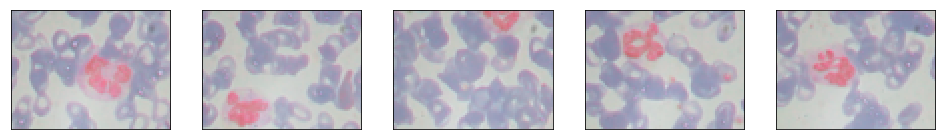

In [14]:
fig = plt.figure(figsize=(20,20))
for i in range(5):
    ax = fig.add_subplot(1, 6, i+1, xticks=[], yticks=[])
    ax.imshow(images[i])

## Encode Categorical String Labels Using a One-Hot Scheme

In [15]:
type_labels = {}
countDict = {} # create dictionary for number of class instances
for bt in blood_types:
    if bt != 'BASOPHIL':
        type_labels[bt] = []
        countDict[bt] = 0


# create data frame from type_labels dictionary
type_labels = pd.DataFrame(type_labels)

# encode
for tp in labels['Type']:
    row = [0, 0, 0, 0]
    if tp.find('LYMPHOCYTE') != -1:
        row[0] = 1
        countDict['LYMPHOCYTE'] +=1
    if tp.find('MONOCYTE') != -1:
        row[1] = 1
        countDict['MONOCYTE'] +=1
    if tp.find('EOSINOPHIL') != -1:
        row[2] = 1
        countDict['EOSINOPHIL'] +=1
    if tp.find('NEUTROPHIL') != -1:
        row[3] = 1
        countDict['NEUTROPHIL'] +=1
    # add row values
    s = pd.Series({'LYMPHOCYTE': row[0],
                  'MONOCYTE': row[1],
                  'EOSINOPHIL': row[2], 
                  'NEUTROPHIL': row[3]
                  })
    # add row to dataframe
    type_labels = type_labels.append(s, ignore_index=True).astype(np.uint8)

type_labels.head(11)


,EOSINOPHIL,LYMPHOCYTE,MONOCYTE,NEUTROPHIL
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
5,0,0,0,1
6,0,0,0,1
7,0,0,0,1
8,1,0,0,0
9,1,0,0,1


  
## Splitting data


In [16]:
from sklearn.model_selection  import train_test_split
# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(images, type_labels, test_size=0.20, random_state=7)

print("Total size of dataset:", len(images))
print("Size of training set:", len(X_train))
print("Size of testing set:", len(X_test))


Total size of dataset: 361
Size of training set: 288
Size of testing set: 73


## Rescale the Images

In [17]:
X_train = np.array(X_train)
X_train = X_train/255.0

X_test = np.array(X_test)
X_test = X_test/255.0

## Make validation set

In [18]:
validation_split = 0.2
num_of_validation = int(len(X_train) * validation_split)

X_validation = X_train[len(X_train) - num_of_validation-1:-1]
y_validation = y_train[len(y_train) - num_of_validation-1:-1]

X_train = X_train[:len(X_train) - num_of_validation]
y_train = y_train[:len(y_train) - num_of_validation]

print("(training, validation) : (", len(X_train),",",len(X_validation),")")

(training, validation) : ( 231 , 57 )


# Data augmentation

In [19]:
from keras.preprocessing import image

datagen_train = image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

datagen_train.fit(X_train, augment=True)

# constructing class weights
weightFunction = lambda x : 1./x**0.75

i = 0
class_weight_dic = {}
for _ , count in countDict.items() :
    class_weight_dic[i] = weightFunction(count)
    i +=1
class_weight_dic

Using TensorFlow backend.


{0: 0.06665745174485568,
 1: 0.09844258048490881,
 2: 0.03312486445189117,
 3: 0.01781029672748746}

## Visualizing augmented data 

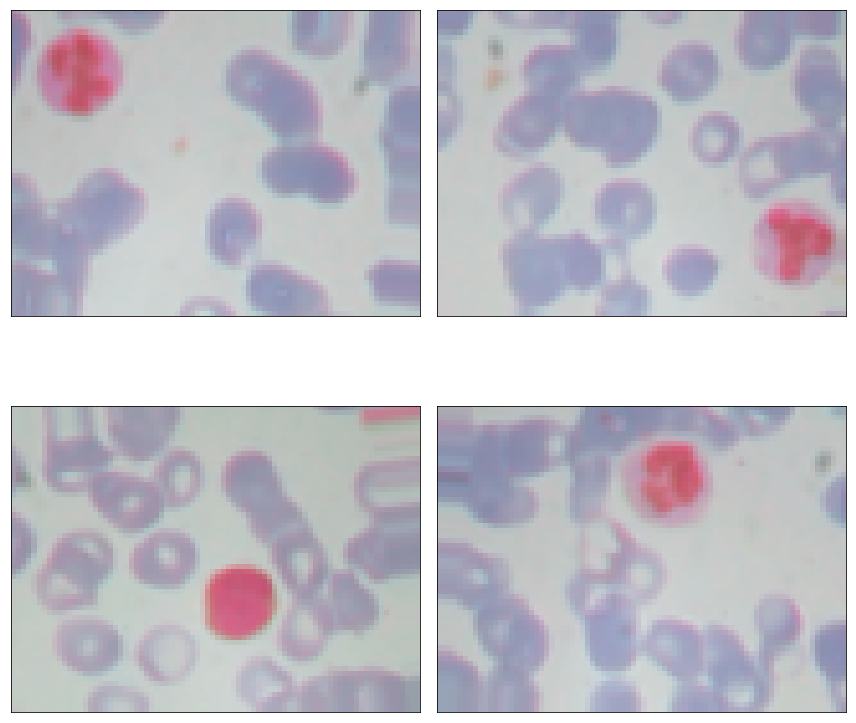

In [20]:
def plotImages( images_arr, n_images=2):
    fig, axes = plt.subplots(n_images, n_images, figsize=(12,12))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        
        ax.imshow( img, cmap="Greys_r")
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()


# visualization of some images out of the preprocessing
augmented_images, _ = next( datagen_train.flow(X_train, y_train))
plotImages( augmented_images)




# Model Architecture

In [21]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

# define parameters
batch_size = 32
epochs = 50
img_rows = 60
img_cols = 80
input_shape = (img_rows, img_cols, 3)
num_classes = len(y_train.iloc[0])


# create the model and define the architecture.
model = Sequential()
#
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
# output layer
model.add(Dense(num_classes, activation='softmax'))


print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'training samples')
model.summary()


X_train shape: (231, 60, 80, 3)
231 training samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 80, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 40, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 40, 128)       32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 20, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 20, 256)       131328    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 10, 256)        0         
_________________________________________________________________
dropout_1 (Dropout)    

## Compile the Model

In [22]:
import keras

#compile
import keras
model.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['accuracy'])


## Calculate the Classification Accuracy on the Test Set (Before Training)

In [27]:
# evaluate test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 6.8493%


## Train the Model

In [28]:
from keras.callbacks import ModelCheckpoint   

# train the model
checkpointer = ModelCheckpoint(filepath='mnist.model.best.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit_generator(
        datagen_train.flow(X_train, y_train, batch_size=batch_size),
        steps_per_epoch=len(X_train)/batch_size,
        epochs=epochs,
        validation_data=[X_validation, y_validation],
        validation_steps=len(X_validation)/batch_size,
        callbacks=[checkpointer],
        verbose = 1,
        class_weight=class_weight_dic)


Epoch 1/50
8/7 [=================================] - 11s 1s/step - loss: 0.0543 - acc: 0.2733 - val_loss: 1.3493 - val_acc: 0.2632

Epoch 00001: val_loss improved from inf to 1.34932, saving model to mnist.model.best.hdf5
Epoch 2/50
8/7 [=================================] - 9s 1s/step - loss: 0.0581 - acc: 0.2304 - val_loss: 1.2848 - val_acc: 0.2632

Epoch 00002: val_loss improved from 1.34932 to 1.28485, saving model to mnist.model.best.hdf5
Epoch 3/50
8/7 [=================================] - 8s 1s/step - loss: 0.0540 - acc: 0.2580 - val_loss: 1.2748 - val_acc: 0.2632

Epoch 00003: val_loss improved from 1.28485 to 1.27482, saving model to mnist.model.best.hdf5
Epoch 4/50
8/7 [=================================] - 8s 988ms/step - loss: 0.0542 - acc: 0.2981 - val_loss: 1.3446 - val_acc: 0.0877

Epoch 00004: val_loss did not improve from 1.27482
Epoch 5/50
8/7 [=================================] - 8s 1s/step - loss: 0.0527 - acc: 0.2298 - val_loss: 1.2767 - val_acc: 0.2632

Epoch 00005:


Epoch 00044: val_loss did not improve from 1.24776
Epoch 45/50
8/7 [=================================] - 8s 980ms/step - loss: 0.0516 - acc: 0.2694 - val_loss: 1.2643 - val_acc: 0.2632

Epoch 00045: val_loss did not improve from 1.24776
Epoch 46/50
8/7 [=================================] - 8s 996ms/step - loss: 0.0537 - acc: 0.2778 - val_loss: 1.3014 - val_acc: 0.2632

Epoch 00046: val_loss did not improve from 1.24776
Epoch 47/50
8/7 [=================================] - 8s 971ms/step - loss: 0.0520 - acc: 0.2778 - val_loss: 1.2848 - val_acc: 0.2632

Epoch 00047: val_loss did not improve from 1.24776
Epoch 48/50
8/7 [=================================] - 8s 982ms/step - loss: 0.0542 - acc: 0.2902 - val_loss: 1.3054 - val_acc: 0.2632

Epoch 00048: val_loss did not improve from 1.24776
Epoch 49/50
8/7 [=================================] - 8s 973ms/step - loss: 0.0539 - acc: 0.3026 - val_loss: 1.3061 - val_acc: 0.2632

Epoch 00049: val_loss did not improve from 1.24776
Epoch 50/50
8/7 [=

## Load the Model with the Best Classification Accuracy on the Validation Set

In [29]:
# load the weights that yielded the best validation accuracy
model.load_weights('mnist.model.best.hdf5')


## Confusion Matrix

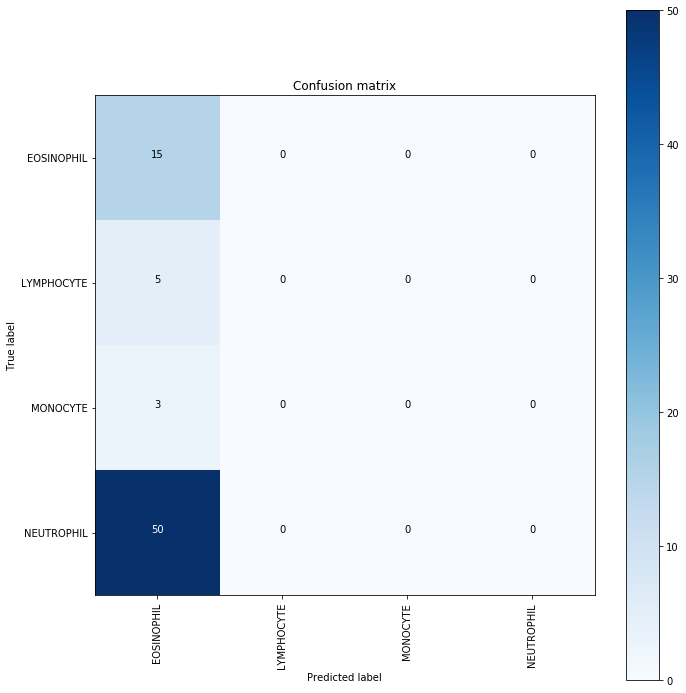

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_true = np.argmax(np.array(y_test), axis=1)
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = y_test.columns) 
plt.show()


## Classification Report

In [32]:
print(classification_report(y_true, y_pred_classes, target_names=y_test.columns))

             precision    recall  f1-score   support

 EOSINOPHIL       0.21      1.00      0.34        15
 LYMPHOCYTE       0.00      0.00      0.00         5
   MONOCYTE       0.00      0.00      0.00         3
 NEUTROPHIL       0.00      0.00      0.00        50

avg / total       0.04      0.21      0.07        73



C:\Users\lenovo pc\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Calculate the Classification Accuracy on the Test Set


In [33]:
# evaluate test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)


Test accuracy: 20.5479%


## Model Performance Summary

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


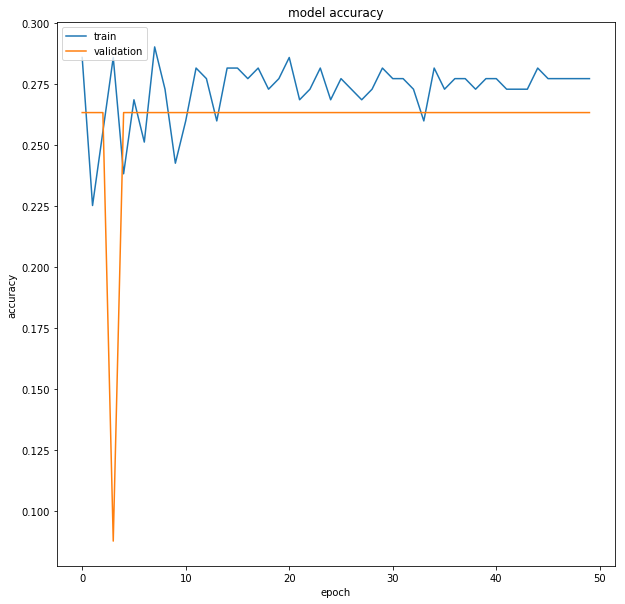

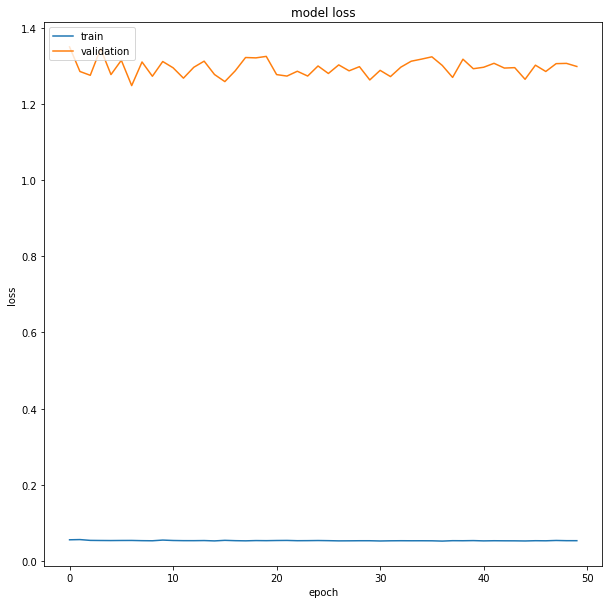

In [34]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.figure(figsize = (10,10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize = (10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Transfer Learning

In [ ]:

# TODO
